fives 0
fives 1
fives 2
fives 3
fives 4
fives 5
fives 6
fives 7
sixes 0
sixes 1
sixes 2
sixes 3
sixes 4
sixes 5
sixes 6
sixes 7
sixes 8
sevens 0
sevens 1
sevens 2
sevens 3
sevens 4
sevens 5
sevens 6
sevens 7
sevens 8
eights 0
eights 1
eights 2
eights 3
eights 4
eights 5
eights 6
eights 7
eights 8
eights 9
nines 0
nines 1
nines 2
nines 3
nines 4
nines 5
nines 6
nines 7
people 0
people 1
people 2
people 3


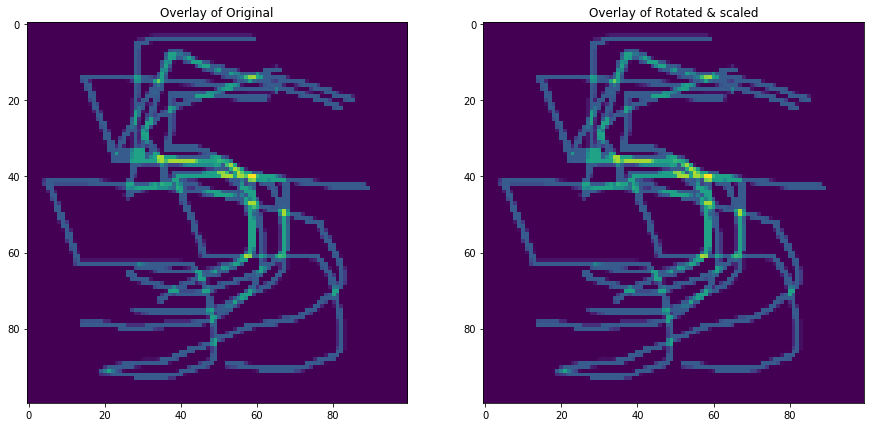

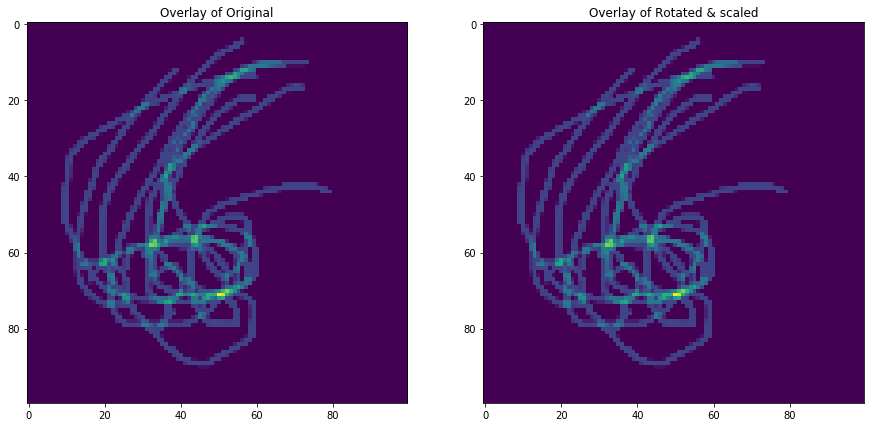

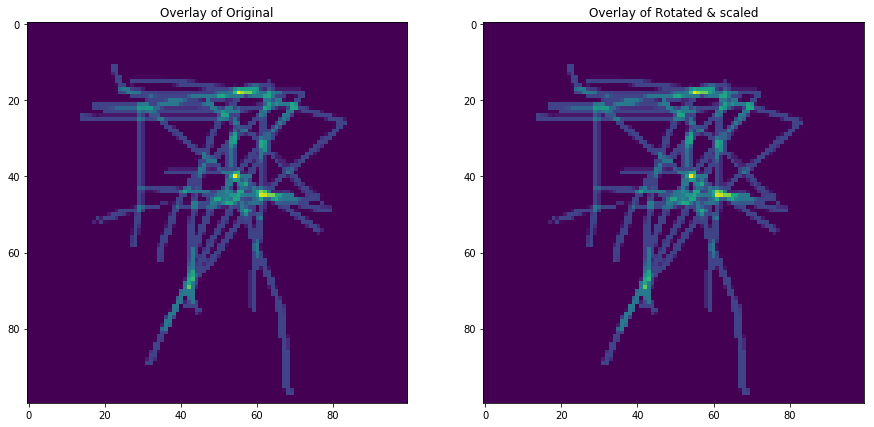

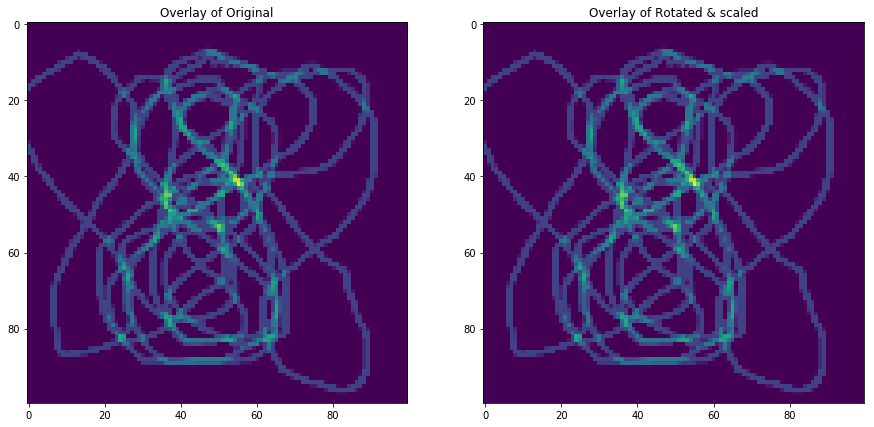

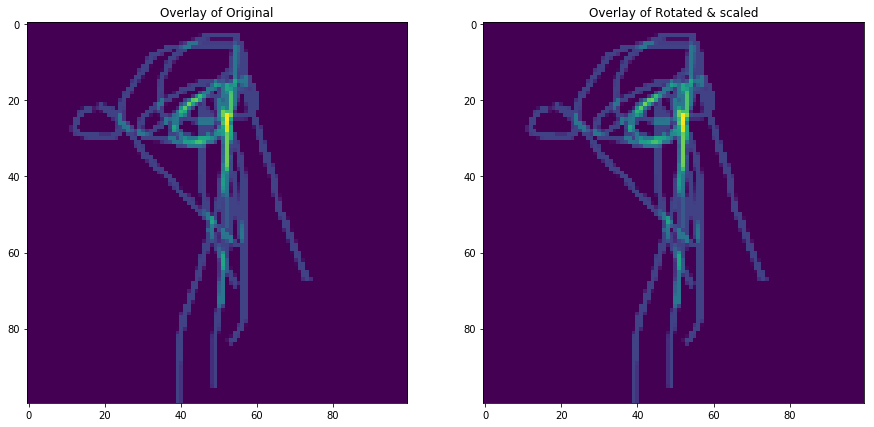

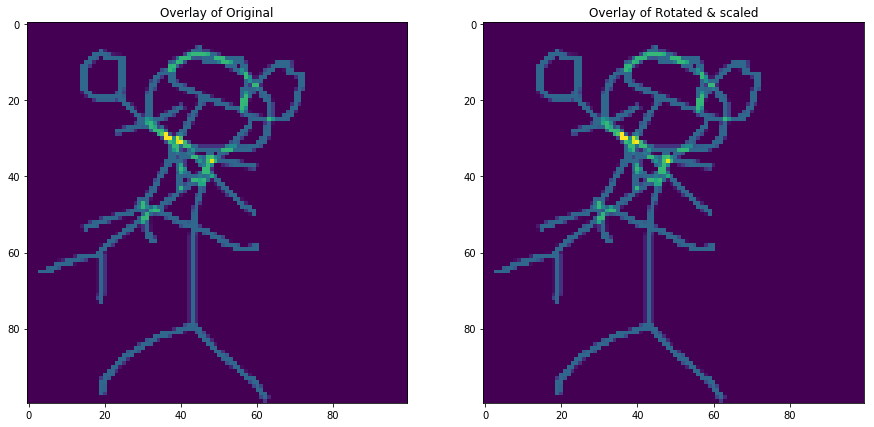

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import time
from natsort import natsorted
import matplotlib.cm as cm
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import mnist
cmap = cm.hot

def get_img_files(folder):
    files = list(filter(lambda file: any(ext in file.lower() for ext in ['png','jpg','bmp']), os.listdir(folder)))
    files = natsorted(files)[::1]
    images = list(map(lambda x: cv2.imread(folder+'/'+x, 0), files))
    return np.array(images)

def img_to_coord(img):
    coord_mat = np.zeros((3, img.shape[0]*img.shape[1]))
    count = 0
    for x in range(img.shape[1]):
        for y in range(img.shape[0]):
            coord_mat[0, count] = x
            coord_mat[1, count] = img.shape[0]-y
            coord_mat[2, count] = img[y, x]
            count += 1
    return coord_mat

def img_to_coord_tensor(img):
    height, width = img.shape
    img_transpose = torch.transpose(img, 0, 1).contiguous().view(1, width * height)

    x_coord = torch.arange(0, width).view(width, 1)
    x_coord = x_coord.expand(width, height).contiguous()
    x_coord = x_coord.view(1, width * height)

    y_coord = torch.arange(height, 0, -1)
    y_coord = y_coord.expand(width, height).contiguous()
    y_coord = y_coord.view(1, width * height)

    new_coord_matrix = np.vstack([x_coord.numpy(), y_coord.numpy()])
    img_tensor = np.vstack([new_coord_matrix, img_transpose.data.numpy()])

    return img_tensor

def plot_coord_mat(coord_mat, ax):
    ax.scatter(coord_mat[0, :], coord_mat[1, :], c=coord_mat[2, :])

def rotation_matrix(degrees):
    theta = np.radians(degrees)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c,-s, 0), (s, c, 0), (0, 0, 1)))
    return R

def weighted_pca_regression(x_vec, y_vec, weights):
    """
    Given three real-valued vectors of same length, corresponding to the coordinates
    and weight of a 2-dimensional dataset, this function outputs the angle in radians
    of the line that aligns with the (weighted) average and main linear component of
    the data. For that, first a weighted mean and covariance matrix are computed.
    Then u,e,v=svd(cov) is performed, and u * f(x)=0 is solved.
    """
    input_mat = np.stack([x_vec, y_vec])
    weights_sum = weights.sum()
    # Subtract (weighted) mean and compute (weighted) covariance matrix:
    mean_x, mean_y =  weights.dot(x_vec)/weights_sum, weights.dot(y_vec)/weights_sum
    centered_x, centered_y = x_vec-mean_x, y_vec-mean_y
    matrix_centered = np.stack([centered_x, centered_y])
    weighted_cov = matrix_centered.dot(np.diag(weights).dot(matrix_centered.T)) / weights_sum
    # We know that v rotates the data's main component onto the y=0 axis, and
    # that u rotates it back. Solving u.dot([x,0])=[x*u[0,0], x*u[1,0]] gives
    # f(x)=(u[1,0]/u[0,0])x as the reconstructed function.
    u,e,v = np.linalg.svd(weighted_cov)
    eig_val = np.sqrt(e)
    if u[1,0] < 0:
        eig_val[0] = -1*eig_val[0]
    if u[0,1] < 0:
        eig_val[1] = -1*eig_val[1]
        
    return eig_val[0]*u[:,0], eig_val[1]*u[:,1], np.array([mean_x, mean_y])
        
def coord_to_img(coord_mat, bbox=[-60,60,-60,60]):
    x_min = bbox[0]
    x_max = bbox[1]
    y_min = bbox[2]
    y_max = bbox[3]
    width = x_max - x_min
    height = y_max - y_min
    
    img = np.zeros([y_max-y_min, x_max-x_min])
    for col in range(coord_mat.shape[1]):
        x = coord_mat[0, col]
        y = coord_mat[1, col]
        val = coord_mat[2, col]
        new_x = int(x - x_min)
        new_y = int(y_max - y)
        if (0 <= new_x) and (new_x < width) and (0 <= new_y) and (new_y < height):
            img[new_y, new_x] = val
    return img

def object_extraction(coord_mat, min_val=0.2):
    min_pixel_val = np.repeat([[min_val]], coord_mat.shape[1], axis=1) 
    extracted_object_coords = np.greater(coord_mat, min_pixel_val)
    new_object = coord_mat.copy()[:,extracted_object_coords[2,:]]
    coord_mat[2,extracted_object_coords[2,:]] = 0
    return new_object

def orientation_normalization(coord_mat):
        weights = coord_mat[2, :]
        primary_vector, seconday_vector, mean_vector = weighted_pca_regression(coord_mat[0,:], coord_mat[1,:], coord_mat[2,:])
        angle = np.arctan2(primary_vector[1], primary_vector[0]) * 180 / np.pi
        R = rotation_matrix(90-angle)
        mean_mat = np.array([mean_vector[0], mean_vector[1], 0])
        mean_mat = np.diag(mean_mat)
        mean_mat = np.matmul(mean_mat, np.ones(coord_mat.shape))
        eig_1 = np.linalg.norm(primary_vector)
        eig_2 = np.linalg.norm(seconday_vector)
        norm_scale_mat = np.zeros([3,3])
        norm_scale_mat[0,0] = 9/eig_2
        norm_scale_mat[1,1] = 18/eig_1
        norm_scale_mat[2,2] = 1
        transformed_mat = np.matmul(norm_scale_mat, np.matmul(R, coord_mat - mean_mat))
        return transformed_mat, R, mean_mat
    
def object_extraction(coord_mat, min_val=0.2):
    min_pixel_val = np.repeat([[min_val]], coord_mat.shape[1], axis=1) 
    extracted_object_coords = np.greater(coord_mat, min_pixel_val)
    new_object = coord_mat.copy()[:,extracted_object_coords[2,:]]
    coord_mat[2,extracted_object_coords[2,:]] = 0
    return new_object

def orientation_normalization(coord_mat):
        weights = coord_mat[2, :]
        primary_vector, seconday_vector, mean_vector = weighted_pca_regression(coord_mat[0,:], coord_mat[1,:], coord_mat[2,:])
        angle = np.arctan2(primary_vector[1], primary_vector[0]) * 180 / np.pi
        R = rotation_matrix(90-angle)
        mean_mat = np.array([mean_vector[0], mean_vector[1], 0])
        mean_mat = np.diag(mean_mat)
        mean_mat = np.matmul(mean_mat, np.ones(coord_mat.shape))
        eig_1 = np.linalg.norm(primary_vector)
        eig_2 = np.linalg.norm(seconday_vector)
        norm_scale_mat = np.zeros([3,3])
        norm_scale_mat[0,0] = 9/eig_2
        norm_scale_mat[1,1] = 18/eig_1
        norm_scale_mat[2,2] = 1
        transformed_mat = np.matmul(norm_scale_mat, np.matmul(R, coord_mat - mean_mat))
        return transformed_mat, R, mean_mat

def erase_object(img, new_object):
    for col_num in range(new_object.shape[1]):
        col = new_object[:,col_num]
        img[img.shape[0]-col[1], col[0]] = 0

def insert_object(img, new_object_coords, location):
    for col_num in range(new_object_coords.shape[1]):
        col = new_object_coords[:, col_num]
        x = np.clip(location[0] + col[0], 0, img.shape[1] - 1)
        y = np.clip(-1*(location[1] + col[1] - 1)+img.shape[0], 0, img.shape[0] - 1)
        spill_over_x = x % 1
        spill_over_y = y % 1
        ceil_x = int(np.ceil(x))
        lower_x_weight = 1 - spill_over_x
        heigher_x_weight = spill_over_x
        
        ceil_y = int(np.ceil(y))
        lower_y_weight = 1 - spill_over_y
        heigher_y_weight = spill_over_y   
        
        pixel_value = col[2]
        max_pixel_val = 0.5
        img[ceil_y, ceil_x] = img[ceil_y, ceil_x] + pixel_value*heigher_y_weight*heigher_x_weight
        img[ceil_y, ceil_x - 1] = img[ceil_y, ceil_x - 1] + pixel_value*lower_x_weight*heigher_y_weight
        img[ceil_y - 1, ceil_x] = img[ceil_y - 1, ceil_x] + pixel_value*lower_y_weight*heigher_x_weight
        img[ceil_y - 1, ceil_x - 1] = img[ceil_y - 1, ceil_x - 1] + pixel_value*lower_y_weight*lower_x_weight
        img[ceil_y, ceil_x] = min(float(img[ceil_y, ceil_x]), max_pixel_val)
        img[ceil_y, ceil_x - 1] = min(float(img[ceil_y, ceil_x - 1]), max_pixel_val)
        img[ceil_y - 1, ceil_x] = min(float(img[ceil_y - 1, ceil_x]), max_pixel_val)
        img[ceil_y - 1, ceil_x - 1] = min(float(img[ceil_y - 1, ceil_x - 1]), max_pixel_val)
#         img[ceil_y, ceil_x] = pixel_value
    return img

def scale_and_rotate(img):
    new_new_coord_mat = img_to_coord_tensor(img)
    test = img_to_coord(img)
    new_object = object_extraction(new_new_coord_mat, min_val=0)
    erase_object(img, new_object)
    new_object2, _, _ = orientation_normalization(new_object)
    img = insert_object(img, new_object2, [50, 50])
    return img
    


for folder in ['fives','sixes','sevens','eights','nines','people'][:]:
    imgs = get_img_files(os.getcwd()+'/'+folder)

    coord_mats = []
    transformed_mats = []
    transformed_mats_2 = []
#     fig, ax = plt.subplots(3, figsize=(10,10))
    for index, img in enumerate(imgs[:]):
        img = cv2.resize(img, (100,100))
        img = img/img.max()
        img = torch.from_numpy(img)
#         img2 = Variable(torch.from_numpy(img))
        img2 = img
        coord_mat = img_to_coord(img)
#         coord_mat_2 = img_to_coord_tensor(img2)
#          plot_coord_mat(, ax[1])
#         ax[0].set_xlim([0,100])
#         ax[0].set_ylim([0,100])
#         ax[1].set_xlim([-60,60])
#         ax[1].set_ylim([-60,60])
#         ax[1].set_title("{}, {}".format(eig_1, eig_2))
#         tansform_mat, R, mean_mat = orientation_normalization(coord_mat.copy())
        coord_mats.append(coord_to_img(coord_mat.copy(), bbox=[0,100,0,100]))
#         transformed_mats_2.append(coord_to_img(np.matmul(R, coord_mat - mean_mat).copy(), bbox=[-60,60,-60,60]))
        
        img2 = scale_and_rotate(img2)
        print(folder, index)
        transformed_mats.append(img2.data.numpy())
        del img2

    fig2, ax2 = plt.subplots(1,2,figsize=(15,15))
    combined_orig = []
    combined_transformed = []
    # plot_coord_mat(coord_mats[0] + coord_mats[1], ax2[0])
    combined_orig = sum(coord_mats)
    combined_transformed = sum(transformed_mats)
#     combined_transformed_2 = sum(transformed_mats_2)
    ax2[0].imshow(combined_orig)
    ax2[0].set_title("Overlay of Original")
#     ax2[1].imshow(combined_transformed_2)
#     ax2[1].set_title("Overlay of Rotated")
    ax2[1].imshow(combined_transformed)
    ax2[1].set_title("Overlay of Rotated & scaled")
#     fig2.savefig("Sevens_full.png")
plt.show()

122.16255366883321 -32.16255366883321
117.727520640735 -27.727520640734994
118.25259238761146 -28.252592387611458
93.45724564681856 -3.4572456468185635
110.39392745233275 -20.393927452332747
77.43160069805647 12.56839930194353
93.0452972402461 -3.0452972402461
90.63832231513912 -0.6383223151391206


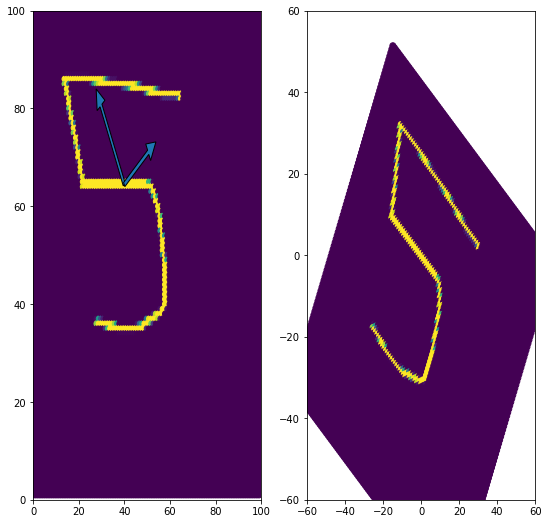

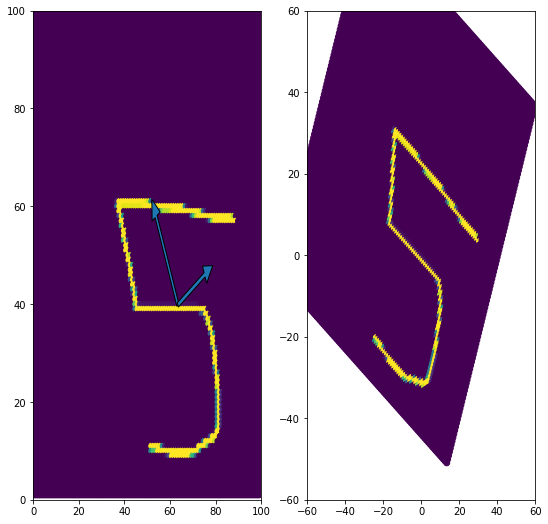

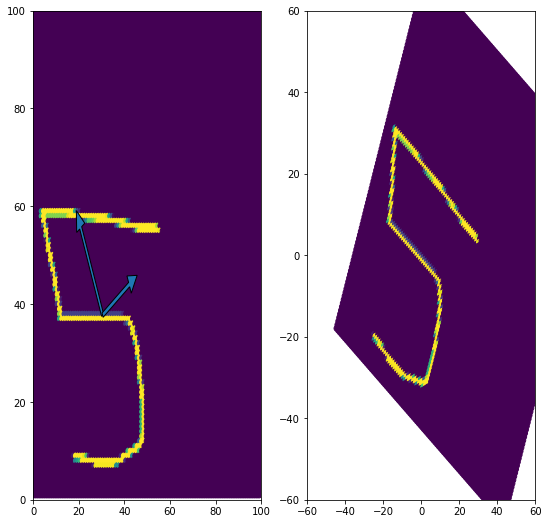

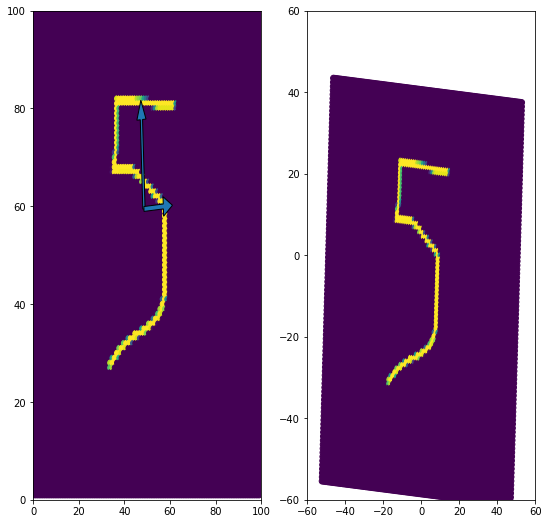

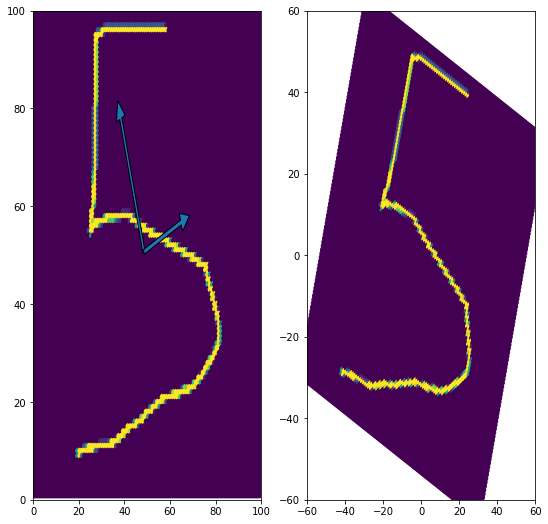

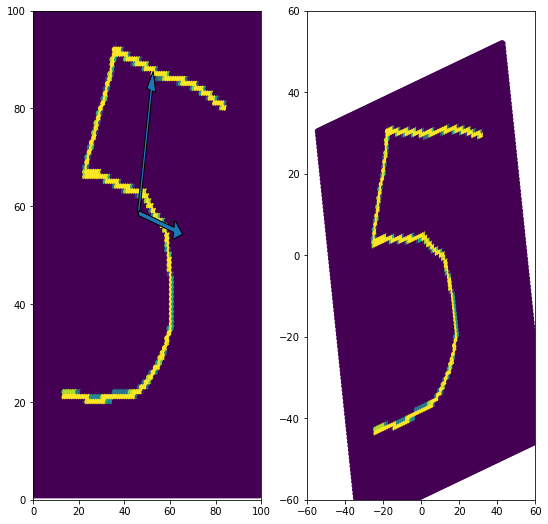

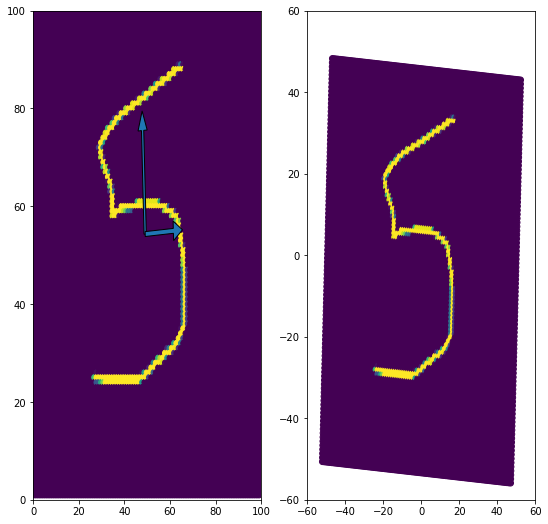

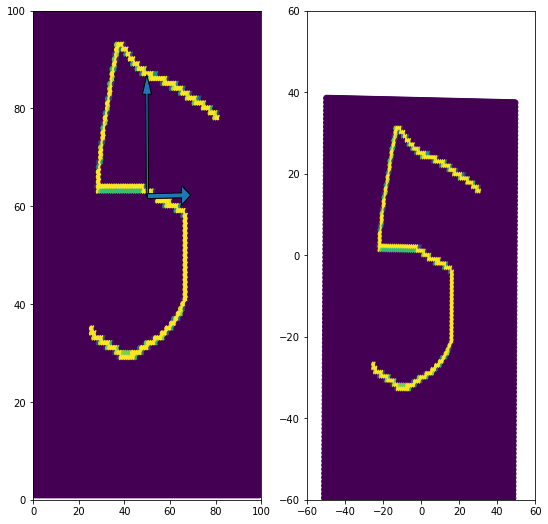

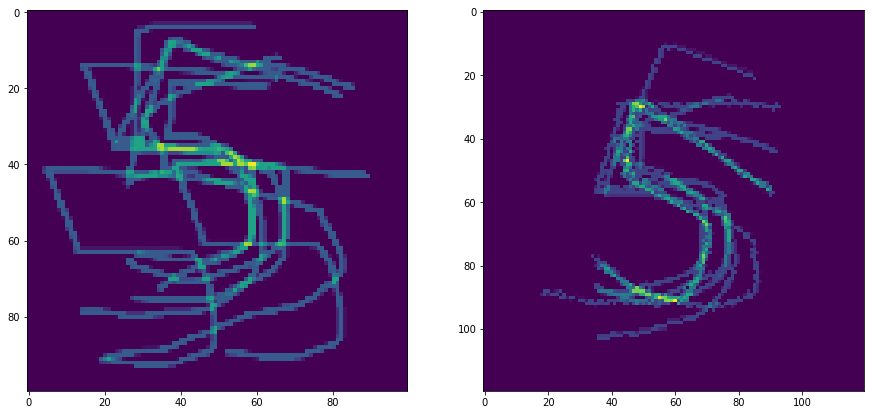

In [7]:

import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import time
from natsort import natsorted
from pandas import DataFrame
import pandas as pd
import matplotlib.cm as cm
cmap = cm.hot

def get_img_files(folder):
    files = list(filter(lambda file: any(ext in file.lower() for ext in ['png','jpg','bmp']), os.listdir(folder)))
    files = natsorted(files)[::1]
    images = list(map(lambda x: cv2.imread(folder+'/'+x, 0), files))
    return np.array(images)

def img_to_coord(img):
    coord_mat = np.ones((3, img.shape[0]*img.shape[1]))
    count = 0
    for x in range(img.shape[1]):
        for y in range(img.shape[0]):
            coord_mat[:, count] = np.array([x, img.shape[0]-y, img[y,x]])
            count += 1
    return coord_mat

def plot_coord_mat(coord_mat, ax):
    ax.scatter(coord_mat[0, :], coord_mat[1, :], c=coord_mat[2, :])

def rotation_matrix(degrees):
    theta = np.radians(degrees)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c,-s, 0), (s, c, 0), (0, 0, 1)))
    return R

def weighted_pca_regression(x_vec, y_vec, weights):
    """
    Given three real-valued vectors of same length, corresponding to the coordinates
    and weight of a 2-dimensional dataset, this function outputs the angle in radians
    of the line that aligns with the (weighted) average and main linear component of
    the data. For that, first a weighted mean and covariance matrix are computed.
    Then u,e,v=svd(cov) is performed, and u * f(x)=0 is solved.
    """
    input_mat = np.stack([x_vec, y_vec])
    weights_sum = weights.sum()
    # Subtract (weighted) mean and compute (weighted) covariance matrix:
    mean_x, mean_y =  weights.dot(x_vec)/weights_sum, weights.dot(y_vec)/weights_sum
    centered_x, centered_y = x_vec-mean_x, y_vec-mean_y
    matrix_centered = np.stack([centered_x, centered_y])
    weighted_cov = matrix_centered.dot(np.diag(weights).dot(matrix_centered.T)) / weights_sum
    # We know that v rotates the data's main component onto the y=0 axis, and
    # that u rotates it back. Solving u.dot([x,0])=[x*u[0,0], x*u[1,0]] gives
    # f(x)=(u[1,0]/u[0,0])x as the reconstructed function.
    u,e,v = np.linalg.svd(weighted_cov)
    eig_val = np.sqrt(e)
    if u[1,0] < 0:
        eig_val[0] = -1*eig_val[0]
    if u[0,1] < 0:
        eig_val[1] = -1*eig_val[1]
        
    return eig_val[0]*u[:,0], eig_val[1]*u[:,1], np.array([mean_x, mean_y])
        
def coord_to_img(coord_mat, bbox=[-60,60,-60,60]):
    x_min = bbox[0]
    x_max = bbox[1]
    y_min = bbox[2]
    y_max = bbox[3]
    width = x_max - x_min
    height = y_max - y_min
    
    img = np.zeros([y_max-y_min, x_max-x_min])
    for col in range(coord_mat.shape[1]):
        x = coord_mat[0, col]
        y = coord_mat[1, col]
        val = coord_mat[2, col]
        new_x = int(x - x_min)
        new_y = int(y_max - y)
        if (0 <= new_x) and (new_x < width) and (0 <= new_y) and (new_y < height):
            img[new_y, new_x] = val
    return img
    
    
# imgs = get_img_files(os.getcwd()+'/images')
img_dict = {}
for folder in ['fives','sixes','sevens','eights','nines','people'][:]:
    img_dict[folder] = get_img_files(os.getcwd()+'/'+folder)

coord_mats = []
transformed_mats = []
# fig, ax = plt.subplots(3, figsize=(10,10))
for index, img in enumerate(img_dict['fives']):
    img = cv2.resize(img, (100,100))
    img = img/img.max()
    fig, ax = plt.subplots(1, 2, figsize=(9,9))
#     ax.imshow(img)
    
    coord_mat = img_to_coord(img)

    weights = coord_mat[2, :]

    primary_vector, seconday_vector, mean_vector = weighted_pca_regression(coord_mat[0,:], coord_mat[1,:], coord_mat[2,:])
    angle = np.arctan2(primary_vector[1], primary_vector[0]) * 180 / np.pi
    print(angle, 90-angle)
    ax[0].arrow(*mean_vector, *(primary_vector), width=1, head_width=4, head_length=4)
    ax[0].arrow(*mean_vector, *(seconday_vector), width=1, head_width=4, head_length=4)
    R = rotation_matrix(90-angle)
    scale_mat = np.zeros([3,3])
    scale_mat[:2,0] = primary_vector/np.linalg.norm(primary_vector)
    scale_mat[:2,1] = seconday_vector/np.linalg.norm(seconday_vector)
    scale_mat[2,2] = 1
    second_scale_mat = np.matmul(scale_mat, np.diag([1, 1, 1]))
    mean_mat = np.array([mean_vector[0], mean_vector[1], 0])
    mean_mat = np.diag(mean_mat)
    mean_mat = np.matmul(mean_mat, np.ones(coord_mat.shape))
    plot_coord_mat(coord_mat, ax[0])
    transformed_mat = np.matmul(R, np.matmul(scale_mat.T,np.matmul(second_scale_mat,coord_mat - mean_mat)) )
#     transformed_mat = np.matmul(scale_mat.T,np.matmul(second_scale_mat,coord_mat - mean_mat))
#     transformed_mat = np.matmul(second_scale_mat,coord_mat - mean_mat)
#     transformed_mat = np.matmul(R, coord_mat - mean_mat)
#     transformed_mat = coord_mat - mean_mat
    plot_coord_mat(transformed_mat, ax[1])
    ax[0].set_xlim([0,100])
    ax[0].set_ylim([0,100])
    ax[1].set_xlim([-60,60])
    ax[1].set_ylim([-60,60])
    
    coord_mats.append(coord_to_img(coord_mat.copy(), bbox=[0,100,0,100]))
    transformed_mats.append(coord_to_img(transformed_mat.copy(), bbox=[-60,60,-60,60]))
    
fig, ax2 = plt.subplots(1,2,figsize=(15,15))
combined_orig = []
combined_transformed = []
# plot_coord_mat(coord_mats[0] + coord_mats[1], ax2[0])
combined_orig = sum(coord_mats)
combined_transformed = sum(transformed_mats)
ax2[0].imshow(combined_orig)
ax2[1].imshow(combined_transformed)
plt.show
# transformed_mats[1][2,:] += transformed_mats[0][2,:]
# plot_coord_mat(coord_mats[0] + coord_mats[1], ax2[0])
# # plot_coord_mat(transformed_mats[0], ax2[1])
# plot_coord_mat(transformed_mats[1], ax2[1])

(1, 322, 386, 3)
Original img channel max 255
torch.Size([1, 3, 322, 386])
(1, 322, 386, 3)


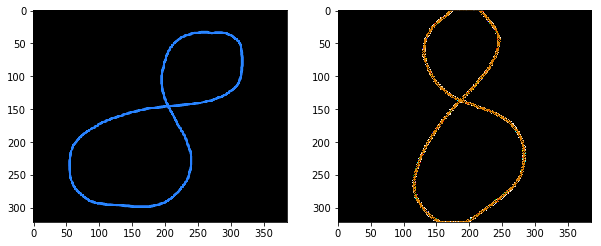

In [3]:
def floor_row(X, row):
    return (np.ceil(X[row])-1).astype(int)

def ceil_row(X, row):
    return (np.ceil(X[row])).astype(int)

def interpolate(X, change_row):
    weights = []
    Y = np.zeros(X.shape)
    for (row, operation) in zip(range(len(X)), change_row):
        Y[row] = operation(X, row)
        weights.append(1 - np.abs(Y[row] - X[row]))
#         print(Y[row])
#     print(weights[0].shape)
#     print(weights[1].shape)
#     print(weights)
    Y[2] = X[2]*weights[0]*weights[1]
    return Y

class RotationScaleNormalization(torch.nn.Module):
    def __init__(self, threshold):
        super(RotationScaleNormalization, self).__init__()
        self.threshold = threshold
        
    def img_to_coord_tensor(self, img, img_num, tensor_index):
        _, _, height, width = img.shape
        flattened_img = torch.transpose(img[img_num, tensor_index], 0, 1).contiguous().view(1, width * height)
        x_coord = torch.arange(0, width).view(width, 1)
        x_coord = x_coord.expand(width, height).contiguous()
        x_coord = x_coord.view(1, width * height)

        y_coord = torch.arange(height, 0, -1)
        y_coord = y_coord.expand(width, height).contiguous()
        y_coord = y_coord.view(1, width * height)

        new_coord_matrix = np.vstack([x_coord.numpy(), y_coord.numpy()])
        img_tensor = np.vstack([new_coord_matrix, flattened_img.data.numpy()])

        return img_tensor

    def rotation_matrix(self, degrees):
        theta = np.radians(degrees)
        c, s = np.cos(theta), np.sin(theta)
        R = np.array(((c,-s, 0), (s, c, 0), (0, 0, 1)))
        return R

    def weighted_pca_regression(self, x_vec, y_vec, weights):
        """
        Given three real-valued vectors of same length, corresponding to the coordinates
        and weight of a 2-dimensional dataset, this function outputs the angle in radians
        of the line that aligns with the (weighted) average and main linear component of
        the data. For that, first a weighted mean and covariance matrix are computed.
        Then u,e,v=svd(cov) is performed, and u * f(x)=0 is solved.
        """
        input_mat = np.stack([x_vec, y_vec])
        weights_sum = weights.sum()
        # Subtract (weighted) mean and compute (weighted) covariance matrix:
        mean_x, mean_y =  weights.dot(x_vec)/weights_sum, weights.dot(y_vec)/weights_sum
        centered_x, centered_y = x_vec-mean_x, y_vec-mean_y
        matrix_centered = np.stack([centered_x, centered_y])
        weighted_cov = matrix_centered.dot(np.diag(weights).dot(matrix_centered.T)) / weights_sum
        # We know that v rotates the data's main component onto the y=0 axis, and
        # that u rotates it back. Solving u.dot([x,0])=[x*u[0,0], x*u[1,0]] gives
        # f(x)=(u[1,0]/u[0,0])x as the reconstructed function.
        u,e,v = np.linalg.svd(weighted_cov)
        eig_val = np.sqrt(e)
        if u[1,0] < 0:
            eig_val[0] = -1*eig_val[0]
        if u[0,1] < 0:
            eig_val[1] = -1*eig_val[1]

        return eig_val[0]*u[:,0], eig_val[1]*u[:,1], np.array([mean_x, mean_y])

    def orientation_normalization(self, coord_mat, eig_width, eig_height):
        weights = coord_mat[2, :]
        primary_vector, seconday_vector, mean_vector = self.weighted_pca_regression(coord_mat[0,:], coord_mat[1,:], coord_mat[2,:])
        angle = np.arctan2(primary_vector[1], primary_vector[0]) * 180 / np.pi
        R = rotation_matrix(90-angle)
        mean_mat = np.array([mean_vector[0], mean_vector[1], 0])
        mean_mat = np.diag(mean_mat)
        mean_mat = np.matmul(mean_mat, np.ones(coord_mat.shape))
        eig_1 = np.linalg.norm(primary_vector)
        eig_2 = np.linalg.norm(seconday_vector)
        norm_scale_mat = np.zeros([3,3])
        norm_scale_mat[0,0] = 1
        norm_scale_mat[1,1] = 1
        norm_scale_mat[2,2] = 1
        transformed_mat = np.matmul(norm_scale_mat, np.matmul(R, coord_mat - mean_mat))
        return transformed_mat, (90-angle), mean_mat

    def object_extraction(self, coord_mat, min_val=0.2):
        min_pixel_val = np.repeat([[min_val]], coord_mat.shape[1], axis=1) 
        extracted_object_coords = np.greater(coord_mat, min_pixel_val)
        new_object = coord_mat.copy()[:,extracted_object_coords[2,:]]
        coord_mat[2,extracted_object_coords[2,:]] = 0
        return new_object

    def erase_object(self, img, img_num, tensor_index, new_object):
        _, _, height, width = img.shape
        if new_object.shape[1] == 0:
            return None
#         print(img_num)
#         print(tensor_index)
#         print(new_object.shape, len(new_object))

        img[np.array([img_num]), np.array([tensor_index]), height - new_object[1, :], new_object[0, :]] = torch.FloatTensor(new_object.shape[1]).zero_()

    def insert_object2(self, img, img_num, tensor_index, new_object_coords, location):
        if new_object_coords.shape[1] == 0:
            return img
        _, _, height, width = img.shape
        xs = np.clip(location[0] + new_object_coords[0, :], 0, width - 1)
        ys = np.clip(height - (location[1] + new_object_coords[1, :] - 1), 0, height - 1)
        img[np.array([img_num]), np.array([tensor_index]), ys, xs] = torch.from_numpy(new_object_coords[2, :]).float()
        return img

    def insert_object3(self, img, tensor_index, new_object_coords, location):
        _, height, width = img.shape
        new_object_coords[0] = np.clip(location[0] + new_object_coords[0], 0, width - 1)
        new_object_coords[1] = np.clip(-1*(location[1] + new_object_coords[1] - 1)+ height, 0, height - 1)
        floor_floor = interpolate(new_object_coords, [floor_row, floor_row])
        floor_ceil = interpolate(new_object_coords, [floor_row, ceil_row]) 
        ceil_floor = interpolate(new_object_coords, [ceil_row, floor_row])
        ceil_ceil = interpolate(new_object_coords, [ceil_row, ceil_row])
        inserted_coords = [ceil_ceil, floor_ceil, ceil_floor, floor_floor]
        
        def insert_val(xyz):
#             print(xyz)
            img[tensor_index, int(xyz[1]), int(xyz[0])] = img[tensor_index, int(xyz[1]), int(xyz[0])] + xyz[2]
            img[tensor_index, int(xyz[1]), int(xyz[0])] = min(float(img[tensor_index, int(xyz[1]), int(xyz[0])]), 1.0)
            return xyz
        
        for new_object in inserted_coords:
            np.apply_along_axis(insert_val, 2, new_object.T.reshape((1,) + new_object.shape[::-1] ))
#             xs = new_object[0]
#             ys = new_object[1]
#             new_object
#             img[np.array([tensor_index]), ys, xs] += torch.autograd.Variable(torch.from_numpy(new_object[2, :]).float())
#             img[np.array([tensor_index]), ys, xs] = torch.clamp(img[np.array([tensor_index]), ys, xs], -10, 1.0)
        return img
    
    def insert_object(self, img, tensor_index, new_object_coords, location):
        _, height, width  = img.shape
        for col_num in range(new_object_coords.shape[1]):
            col = new_object_coords[:, col_num]
            x = np.clip(location[0] + col[0], 0, width - 1)
            y = np.clip(-1*(location[1] + col[1] - 1)+ height, 0, height - 1)
            spill_over_x = x % 1
            spill_over_y = y % 1
            ceil_x = int(np.ceil(x))
            lower_x_weight = 1 - spill_over_x
            heigher_x_weight = spill_over_x

            ceil_y = int(np.ceil(y))
            lower_y_weight = 1 - spill_over_y
            heigher_y_weight = spill_over_y   

            pixel_value = col[2]
            max_pixel_val = 1.0
            img[tensor_index, ceil_y, ceil_x] = img[tensor_index, ceil_y, ceil_x] + pixel_value*heigher_y_weight*heigher_x_weight
            img[tensor_index, ceil_y, ceil_x - 1] = img[tensor_index, ceil_y, ceil_x - 1] + pixel_value*lower_x_weight*heigher_y_weight
            img[tensor_index, ceil_y - 1, ceil_x] = img[tensor_index, ceil_y - 1, ceil_x] + pixel_value*lower_y_weight*heigher_x_weight
            img[tensor_index, ceil_y - 1, ceil_x - 1] = img[tensor_index, ceil_y - 1, ceil_x - 1] + pixel_value*lower_y_weight*lower_x_weight
            img[tensor_index, ceil_y, ceil_x] = min(float(img[tensor_index, ceil_y, ceil_x]), max_pixel_val)
            img[tensor_index, ceil_y, ceil_x - 1] = min(float(img[tensor_index, ceil_y, ceil_x - 1]), max_pixel_val)
            img[tensor_index, ceil_y - 1, ceil_x] = min(float(img[tensor_index, ceil_y - 1, ceil_x]), max_pixel_val)
            img[tensor_index, ceil_y - 1, ceil_x - 1] = min(float(img[tensor_index, ceil_y - 1, ceil_x - 1]), max_pixel_val)
        return img
    
    def reorient_basis(self, tensor_img_batch):
        img_num, channel_num, new_height, new_width = tensor_img_batch.shape
        
        for img_index in range(img_num):
            for tensor_index in range(channel_num):
                img_coord_mat = self.img_to_coord_tensor(tensor_img_batch, img_index, tensor_index)
                new_object = self.object_extraction(img_coord_mat, min_val=self.threshold)

                self.erase_object(tensor_img_batch, img_index, tensor_index, new_object)
                new_object2, transform_angle, _ = self.orientation_normalization(new_object, new_width/10, new_height/5)
                self.insert_object2(tensor_img_batch, img_index, tensor_index, new_object2, [new_width/2, new_height/2])        
    
    def forward(self, tensor_img):
        self.reorient_basis(tensor_img)
#         torch.autograd.Variable(torch.Tensor([[int(transform_angle)]]))
        return tensor_img

net = RotationScaleNormalization(0)    # define the network

c_eight = cv2.imread('colored_eight.png')
# c_eight = np.reshape(c_eight, (1,) + c_eight.shape)
c_eight_torch = torch.from_numpy(c_eight)
fig, ax = plt.subplots(1, 2, figsize=(10,10))
# print(c_eight.shape, c_eight_torch.shape)
ax[0].imshow(c_eight)


img2 = c_eight[np.newaxis]
print(img2.shape)
print("Original img channel max", np.max(img2[:, :, :, 2]))
img2 = Variable(torch.from_numpy(  np.transpose(img2, (0, 3, 1, 2))  ).float())

transformed_img2 = net(img2)
print(img2.size())
normed_img = img2.data.numpy()
normed_img = np.transpose(normed_img, (0, 2, 3, 1))
print(normed_img.shape)
ax[1].imshow(normed_img[0, :, :, :])
plt.show()

In [ ]:
import scipy.io as sio
mat_contents = sio.loadmat('/mnt/c/Users/Rees/Downloads/training_and_validation_batches/training_and_validation_batches/1.mat')
nums = mat_contents['affNISTdata']
import matplotlib.pyplot as plt
print(nums[0][0][5].shape)
labels = nums[0][0][5].T
imgs = np.transpose(nums[0][0][2].reshape((40,40, 60000)), (2,0,1))
labels

In [ ]:
index = 200
plt.imshow(imgs[index])
print(imgs[index].shape)
print(labels[index])
plt.show()

In [ ]:
# %matplotlib qt
RotationScaleNormalization

class smallCNN(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.conv(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x


print(net)  # net architecture

# optimizer = torch.optim.SGD(net.parameters(), lr=0.5)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss



for folder in ['fives','sixes','sevens','eights','nines','people'][:1]:
#     imgs = get_img_files(os.getcwd()+'/'+folder)

    coord_mats = []
    transformed_mats = []
    rotation_list = []
    for index, img in enumerate(imgs[:1]):
        print(folder, index)
        img = cv2.resize(img, (100,100))
        img = img/img.max()
        
        img2 = Variable(torch.from_numpy(np.reshape(img, (1, 1, 100, 100))).float())
        
        coord_mat = img_to_coord(img)
        coord_mats.append(coord_to_img(coord_mat.copy(), bbox=[0,100,0,100]))
        
        transformed_img2 = net(img2)
        transformed_mats.append(np.reshape(transformed_img2.data.numpy(), (100,100)))
#         rotation_list.append(rotation)

    fig2, ax2 = plt.subplots(1,2,figsize=(15,15))
    combined_orig = []
    combined_transformed = []
    combined_orig = sum(coord_mats)
    combined_transformed = sum(transformed_mats)

    ax2[0].imshow(combined_orig)
    ax2[0].set_title("Overlay of Original")
    ax2[1].imshow(combined_transformed)
    ax2[1].set_title("Rotated & scaled", )
    
plt.show()

In [ ]:
img_shape = (40,40)

train_images = imgs[:5000]
train_labels = labels[:5000]

test_images = imgs[5000:]
test_labels = labels[5000:]

# train_images = mnist.train_images()
# train_labels = mnist.train_labels()

# test_images = mnist.test_images()
# test_labels = mnist.test_labels()

torch_train_images = torch.from_numpy(train_images)
torch_train_labels = torch.from_numpy(train_labels)

torch_test_images = torch.from_numpy(test_images)
torch_test_labels = torch.from_numpy(test_labels)
print(torch_train_images.shape)
print(torch_train_labels.shape)

print(torch_test_images.shape)
print(torch_test_labels.shape)
train = torch.utils.data.TensorDataset(torch_train_images.view(-1, 1, img_shape[1],img_shape[0]), torch_train_labels.view(-1, 1))
train_loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=False)

test = torch.utils.data.TensorDataset(torch_test_images.view(-1, 1, img_shape[1],img_shape[0]), torch_test_labels.view(-1, 1))
test_loader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=False)

In [ ]:
import torch.utils.data
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(int(img_shape[1]/4)*int(img_shape[0]/4)*32, 10)
        
    def forward(self, x):
        x = x.view(-1, 1, img_shape[0], img_shape[1])
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
        
class rotationCNN(nn.Module):
    def __init__(self):
        super(rotationCNN, self).__init__()
        self.rotation = RotationScaleNormalization(0.1)
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(int(img_shape[1]/4)*int(img_shape[0]/4)*32, 10)
        
    def forward(self, x):
#         out = x.view(-1, 1, img_shape[0], img_shape[1])
#         out = self.rotation(x) 
        out = self.layer1(x)
        out = self.rotation(out) 
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
#         out = torch.cat(out, )
        return out




In [ ]:
num_limit = 1
total_num = 64
fig, ax = plt.subplots(64,2, figsize=(10,150))
count = 0

# cnn = CNN()
# cnn2 = rotationCNN()
# learning_rate = 0.001
# # Loss and Optimizer
# criterion = nn.CrossEntropyLoss()
# criterion2 = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
# optimizer2 = torch.optim.Adam(cnn2.parameters(), lr=learning_rate)
net2 = RotationScaleNormalization(0.05)

specific_batch = np.random.randint(50)

print("LABEL", "CNN", "ROTATION")
for index, batch in enumerate(test_loader):
    if index != num_limit:
        continue
    for index2, (img, label) in enumerate(zip(batch[0],batch[1])):
        if index2 >= total_num:
            break
        img2 = img.clone()
        img = img.view(1, 1,img_shape[1],img_shape[0])
        test_img = Variable(img.float()/img.max())
        test_img2 = Variable(img2.view(1, 1,img_shape[1],img_shape[0]).float()/img2.max())

        outputs2 = cnn2(test_img)
        _, prediction2 = torch.max(outputs2.data, 1)
    
        outputs = cnn(test_img)
        _, prediction = torch.max(outputs.data, 1)
        
        digit_num = int(prediction[0])
        digit_num2 = int(prediction2[0])

        print(int(label), digit_num, digit_num2)
#         if int(label) == 6:
        ax[count, 0].set_title(digit_num2)
        ax[count, 0].axis('off')
        ax[count, 1].axis('off')
        ax[count, 0].imshow(np.reshape(img2, (img_shape[1],img_shape[0])))
        rotation = 1
        rotated_img  = net2(test_img2)
        ax[count, 1].imshow(np.reshape(rotated_img.data.numpy(), (img_shape[1],img_shape[0])))
        ax[count, 1].set_title(int(rotation))
        count += 1
        
        
plt.subplots_adjust(hspace=0.5)
        
#     new_img = new_img.numpy()
#     new_img = new_img/new_img.max()
#     torch_img = Variable(torch.from_numpy(new_img))
#     ax[count, 0].set_title(new_label)
#     ax[count, 0].imshow(new_img)
#     ax[count, 1].imshow(net2(torch_img).data.numpy())
#     count += 1

plt.show()

In [ ]:
# import torch.nn as nn
# # CNN Model (2 conv layer)
# # img_shape = (40,40)
# print()
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(1, 16, kernel_size=5, padding=2),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.MaxPool2d(2))
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(16, 32, kernel_size=5, padding=2),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.MaxPool2d(2))
#         self.fc = nn.Linear(int(img_shape[1]/4)*int(img_shape[0]/4)*32, 10)
        
#     def forward(self, x):
#         x = x.view(-1, 1, img_shape[0], img_shape[1])
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = out.view(out.size(0), -1)
#         out = self.fc(out)
#         return out
        
# class rotationCNN(nn.Module):
#     def __init__(self):
#         super(rotationCNN, self).__init__()
#         self.rotation = RotationScaleNormalization(0.1)
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(1, 16, kernel_size=5, padding=2),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.MaxPool2d(2))
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(16, 32, kernel_size=5, padding=2),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.MaxPool2d(2))
#         self.fc = nn.Linear(int(img_shape[1]/4)*int(img_shape[0]/4)*32, 10)
        
#     def forward(self, x):
# #         out = x.view(-1, 1, img_shape[0], img_shape[1])
#         out, rotation = self.rotation(x) 
#         out = self.layer1(out)
#         out = self.layer2(out)
#         print(out.shape)
        
#         out = out.view(out.size(0), -1)
#         out = self.fc(out)
# #         out = torch.cat(out, )
#         return out

def train_net(model, data_loader, loss_function, optimizer_function, num_epochs=10, num_examples = 10):
    # Train the Model
    for epoch in range(num_epochs):
        for i, batch in enumerate(data_loader):
            if i >= num_examples:
                print("Batch Num", i*epoch)
                break
            input_data = Variable(batch[0].float()/batch[0].max())
            temp_labels = Variable(batch[1].long().squeeze(1))
            # Forward + Backward + Optimize
            optimizer_function.zero_grad()
            outputs = model(input_data)
#             print(outputs.float())
#             print(temp_labels.float())
#             print(input_data.shape)
            loss = loss_function(outputs, temp_labels)
            loss.backward()
            optimizer_function.step()

cnn = CNN()
cnn2 = rotationCNN()
learning_rate = 0.001
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
criterion2 = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
optimizer2 = torch.optim.Adam(cnn2.parameters(), lr=learning_rate)



In [ ]:
train_net(cnn, train_loader, criterion, optimizer)
train_net(cnn2, train_loader, criterion2, optimizer2, 10, 10)
print("DONE!")



In [ ]:
# Test the Model
cnn.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
cnn2.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
correct = 0
total = 0

correct2 = 0
total2 = 0

num_imgs = 500
count = 0
for testing_images, testing_labels in train_loader:
    for image, label in zip(testing_images, testing_labels):
        if count >= num_imgs:
            break
        count += 1
        t_label = label.long()
        t_image = Variable(image.view(1, 1, img_shape[1], img_shape[0]).float())
        t_image2 = t_image.clone()
        t_label2 = t_label.clone()

        outputs2 = cnn2(t_image2)
        _, predicted2 = torch.max(outputs2.data, 1)
        total2 += t_label2.size(0)
        correct2 += (predicted2 == t_label2).sum()
        
        outputs = cnn(t_image)
        _, predicted = torch.max(outputs.data, 1)
        total += t_label.size(0)
        correct += (predicted == t_label).sum()

print('Test Accuracy of the CNN on the {} images {}'.format(num_imgs, 100 * correct / num_imgs))
print('Test Accuracy of the RotationCNN on the {} images {}'.format(num_imgs, 100 * correct2 / num_imgs))


# Save the Trained Model
# torch.save(cnn.state_dict(), 'cnn.pkl')

In [ ]:
img_tensor = Variable(torch.Tensor(coord_mats[0]), requires_grad=False)
img_tensor.shape

height, width = img_tensor.shape
img_tensor = img_tensor.view(1, width * height)

x_coord = Variable(torch.arange(0, width)).view(1, width)

x_coord = x_coord.expand(height, width).contiguous()
x_coord = x_coord.view(1, width * height)
x_coord = x_coord - 50

y_coord = Variable(torch.arange(height - 1,-1,-1).view(height,1))
y_coord = y_coord.expand(width, height).contiguous()
y_coord = y_coord.view(1,width * height)
y_coord = y_coord - 50

fig, ax = plt.subplots(1,2)
coord_mat = torch.cat((x_coord, y_coord))
img_tensor = torch.cat((coord_mat, img_tensor))
R = rotation_matrix(45)
img_tensor = img_tensor.data.numpy()
plot_coord_mat(img_tensor, ax[0])
# print(np.round_(img_tensor))
print()
img_tensor23 = np.matmul(R, img_tensor)
plot_coord_mat(img_tensor23, ax[1])

def coord_mat_to_img(coord_mat, width, height):
    coord_mat = np.round_(coord_mat)
    ind = np.lexsort((coord_mat[0,:],-1*coord_mat[1,:]))
    coord_mat = coord_mat[:,ind]
    pixels = coord_mat[2,:width*height]
    pixels = np.reshape(pixels, (height, width))
    return pixels

fig2, ax2 = plt.subplots(1,2)
ax2[0].imshow(coord_mat_to_img(img_tensor, 100, 100))
ax2[1].imshow(coord_mat_to_img(img_tensor23, 100, 100))
plt.show()

In [ ]:
def object_extraction(coord_mat, min_val=0.2):
    min_pixel_val = np.repeat([[min_val]], coord_mat.shape[1], axis=1) 
    extracted_object_coords = np.greater(coord_mat, min_pixel_val)
    new_object = coord_mat.copy()[:,extracted_object_coords[2,:]]
    coord_mat[2,extracted_object_coords[2,:]] = 0
    return new_object

def orientation_normalization(coord_mat):
        weights = coord_mat[2, :]
        primary_vector, seconday_vector, mean_vector = weighted_pca_regression(coord_mat[0,:], coord_mat[1,:], coord_mat[2,:])
        angle = np.arctan2(primary_vector[1], primary_vector[0]) * 180 / np.pi
        R = rotation_matrix(90-angle)
        mean_mat = np.array([mean_vector[0], mean_vector[1], 0])
        mean_mat = np.diag(mean_mat)
        mean_mat = np.matmul(mean_mat, np.ones(coord_mat.shape))
        eig_1 = np.linalg.norm(primary_vector)
        eig_2 = np.linalg.norm(seconday_vector)
        norm_scale_mat = np.zeros([3,3])
        norm_scale_mat[0,0] = 9/eig_2
        norm_scale_mat[1,1] = 18/eig_1
        norm_scale_mat[2,2] = 1
        transformed_mat = np.matmul(norm_scale_mat, np.matmul(R, coord_mat - mean_mat))
        return transformed_mat

def insert_object(img, new_object_coords, location):
    for col_num in range(new_object_coords.shape[1]):
        col = new_object_coords[:, col_num]
        x = np.clip(location[0] + col[0], 0, img.shape[1] - 1)
        y = np.clip(-1*(location[1] + col[1] - 1)+img.shape[0], 0, img.shape[0] - 1)
        spill_over_x = x % 1
        spill_over_y = y % 1
        ceil_x = int(np.ceil(x))
        lower_x_weight = 1 - spill_over_x
        heigher_x_weight = spill_over_x
        
        ceil_y = int(np.ceil(y))
        lower_y_weight = 1 - spill_over_y
        heigher_y_weight = spill_over_y   
        
        pixel_value = col[2]
        max_pixel_val = 0.5
        img[ceil_y, ceil_x] += pixel_value*heigher_y_weight*heigher_x_weight
        img[ceil_y, ceil_x - 1] += pixel_value*lower_x_weight*heigher_y_weight
        img[ceil_y - 1, ceil_x] += pixel_value*lower_y_weight*heigher_x_weight
        img[ceil_y - 1, ceil_x - 1] += pixel_value*lower_y_weight*lower_x_weight
        img[ceil_y, ceil_x] = min(img[ceil_y, ceil_x], max_pixel_val)
        img[ceil_y, ceil_x - 1] = min(img[ceil_y, ceil_x - 1], max_pixel_val)
        img[ceil_y - 1, ceil_x] = min(img[ceil_y - 1, ceil_x], max_pixel_val)
        img[ceil_y - 1, ceil_x - 1] = min(img[ceil_y - 1, ceil_x - 1], max_pixel_val)
#         img[ceil_y, ceil_x] = pixel_value
    return img


fig, ax = plt.subplots(1,4, figsize=(30,10))
copy_tensor = img_tensor.copy()
img_tensor2 = img_tensor.copy()
# np.round_(img_tensor2[img_tensor2[1:] > 25])
plot_coord_mat(copy_tensor, ax[1])

 

# bigger = np.logical_and(bigger[0,:],bigger[1,:])

# less = np.less(img_tensor2, max_box)
# # less = np.logical_and(less[0,:],less[1,:])
# img_tensor2 = img_tensor2[:,less[2,:]]
new_object = object_extraction(img_tensor2, min_val=0.05)
plot_coord_mat(new_object, ax[0])
# plot_coord_mat(img_tensor2, ax[2])
new_object2 = orientation_normalization(new_object.copy())
plot_coord_mat(new_object2, ax[3])
new_img = coord_mat_to_img(img_tensor2, 64, 64)
new_img = np.zeros(new_img.shape)
new_img = insert_object(new_img, new_object2, [29,35])

ax[2].imshow(new_img[:,:])
plt.show()
    
    
    

In [ ]:
data = np.array([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]])
X = torch.ByteTensor([data.tolist(), (data+5).tolist()])
Y = torch.ByteTensor(data.tolist())
print(X, X.shape)
x = np.array([0, 2, 1])
y = np.array([2, 2, 0])
print(Y[2-y, x])
X[[0], 2-y,x]
# y = x[0, :, :]
# z = y[[0,2]]
# q = z[[0,2]]
# print(q)
# q = torch.ByteTensor(np.array([[1,1],[1,1]]))
# print(q)
# print(x)

In [ ]:
A = np.array([[1.1,2.2, 1],[3.5,4.5, 1],[5.7,6.7, 1],[7.8,8.8, 1],[9.9, 10.1, 1]]).T
print(A)
print(A.shape)
# X[0, :] = np.floor(X[0, :])
# pixel_value*heigher_y_weight*heigher_x_weight
# pixel_value*lower_x_weight*heigher_y_weight
# pixel_value*lower_y_weight*heigher_x_weight
# pixel_value*lower_y_weight*lower_x_weight
# ceil_x = int(np.ceil(x))
# lower_x_weight = 1 - spill_over_x
# heigher_x_weight = spill_over_x

# ceil_y = int(np.ceil(y))
# lower_y_weight = 1 - spill_over_y
# heigher_y_weight = spill_over_y   
def floor_row(X, row):
    return (np.ceil(X[row])-1).astype(np.uint)

def ceil_row(X, row):
    return (np.ceil(X[row])).astype(np.uint)

def interpolate(X, change_row):
    weights = []
    Y = np.zeros(A.shape)
    for (row, operation) in zip(range(len(X)), change_row):
        Y[row] = operation(X, row)
        weights.append(1 - np.abs(Y[row] - X[row]))
#     print(weights)
    Y[2] = X[2]*weights[0]*weights[1]
    return Y
            
            
print('original\n', A, A.shape)
print('f_f\n', interpolate(A, [floor_row, floor_row]), interpolate(A, [floor_row, floor_row]).shape)
print('f_c\n', interpolate(A, [floor_row, ceil_row]))
print('c_f\n', interpolate(A, [ceil_row, floor_row]))
print('c_c\n', interpolate(A, [ceil_row, ceil_row]))

In [ ]:
R = np.array([[1.1,2.2, 1],[1.2,2.3, 1],[5.7,6.7, 1],[7.8,8.8, 1],[9.9, 10.1, 1]]).T
R_IMG = np.zeros((11,11))
R_IMG2 = R_IMG.copy()
R_f_f = interpolate(R, [floor_row, floor_row])
def F(X):
#     print(X[1], X[0], X[2])
    R_IMG[int(X[1]), int(X[0])] += X[2]
    return X
print(R)
print(R_f_f)
print(R_f_f[1])
print(R_f_f[0])
print()
rfft = R_f_f.T.reshape((1,5,3))
%time np.apply_along_axis(F, 2, rfft)
%time R_IMG[R_f_f[1].astype(int), R_f_f[0].astype(int)] = R_IMG[R_f_f[1].astype(int), R_f_f[0].astype(int)] + R_f_f[2]
print(R_IMG.max())
fig, ax = plt.subplots(1, 2)
# R_IMG2[]
ax[0].imshow(R_IMG)

plt.show()

In [ ]:
a = 1
b = [1,2,3]
map(lambda x: a = x, b)